In [6]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess_input

model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                          include_top=True,
                                          weights='imagenet')

In [7]:

def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)

imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)  
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

img = {'Peacock':'Peacock.jpg'}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img.items()}

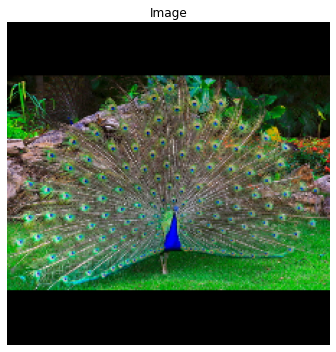

In [8]:
plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.imshow(img_name_tensors['Peacock'])
ax.set_title("Image")
ax.axis('off')
plt.tight_layout()

In [10]:
img = img_name_tensors['Peacock']
image = tf.expand_dims(img, 0)
predictions = model(image)
predictions

<tf.Tensor: shape=(1, 1000), dtype=float32, numpy=
array([[3.48803209e-04, 8.24705930e-04, 5.99021805e-05, 4.90967417e-04,
        6.41921884e-04, 9.13317315e-03, 4.79739392e-03, 2.68215459e-04,
        6.70242705e-04, 2.41079892e-04, 9.82326819e-05, 4.07206448e-04,
        4.07236133e-04, 4.24570608e-04, 5.41536137e-04, 1.23633828e-04,
        2.46959156e-04, 7.86085206e-04, 9.39722289e-04, 3.78314639e-04,
        4.91528190e-04, 2.96325277e-04, 1.18760427e-03, 2.35751690e-03,
        1.03056640e-03, 5.18005872e-05, 8.70696749e-05, 1.52500928e-04,
        1.41124856e-05, 1.46796825e-04, 1.67344362e-04, 4.48903418e-04,
        1.00426681e-04, 9.78459720e-05, 7.78550282e-04, 1.19769116e-04,
        3.12486154e-05, 6.33890158e-05, 3.65175918e-04, 1.09590859e-04,
        4.46513470e-04, 6.84500483e-05, 1.43620593e-04, 1.03245162e-04,
        1.34224625e-04, 1.03778235e-04, 2.89815827e-04, 3.94647330e-04,
        1.47677798e-04, 1.41022421e-04, 6.21649437e-04, 6.71684684e-04,
        7.436

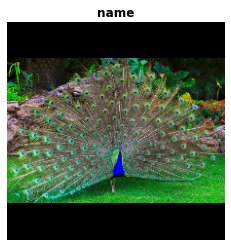

peacock: 0.2%
sea anemone: 0.1%
coral reef: 0.1%


In [4]:
def top_k_predictions(img, k=3):
  image = tf.expand_dims(img, 0)
  predictions = model(image)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = np.array(tuple(top_idxs[0]) )
  return top_labels, top_probs[0]#Display the image with top 3 prediction from the model

plt.imshow(img_name_tensors['Peacock'])
plt.title("name", fontweight='bold')
plt.axis('off')
plt.show()


pred_label, pred_prob = top_k_predictions(img_name_tensors['Peacock'])
for label, prob in zip(pred_label, pred_prob):
    print(f'{imagenet_labels[label+1]}: {prob:0.1%}')


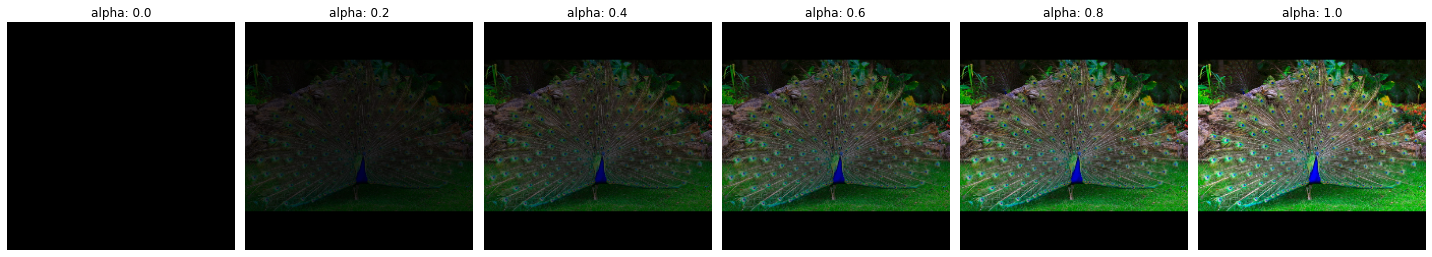

In [5]:
baseline = tf.zeros(shape=(224,224,3))

m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['Peacock'],
    alphas=alphas)

fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

In [6]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)


path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=84)

def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [1]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=1):
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
  # Initialize TensorArray outside loop to collect gradients.    
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
    
  # Iterate alphas range and batch computation for speed, memory #efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]# 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)# 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    
  
    # Stack path gradients together row-wise into single tensor.
    total_gradients = gradient_batches.stack()# 4. Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)# 5. Scale integrated gradients with respect to input.
    integrated_gradients = (image - baseline) * avg_gradients
  return integrated_gradients


ig_attributions = integrated_gradients(baseline=baseline,
                                        image=img_name_tensors['Peacock'],
                                        target_class_idx=84,
                                        m_steps=283)

NameError: name 'tf' is not defined

In [ ]:
def plot_img_IG(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):
  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
  fig, axs = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=   (8, 8))
  axs[0, 0].set_title('Attribution mask')
  axs[0, 0].imshow(attribution_mask, cmap=cmap)
  axs[0, 0].axis('off')  
  axs[0, 1].set_title('Overlay IG on Input image ')
  axs[0, 1].imshow(attribution_mask, cmap=cmap)
  axs[0, 1].imshow(image, alpha=overlay_alpha)
  axs[0, 1].axis('off')  
  plt.tight_layout()
  return fig

_ = plot_img_IG(image=img_name_tensors['Peacock'],
                          baseline=baseline,
                          target_class_idx=84,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)